In [193]:
import pandas as pd
import geopandas as gp
from sqlalchemy import create_engine
import requests
from tqdm import tqdm
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge, PoissonRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

import config as cfg

API_KEY = cfg.CENSUS_API_KEY

# Cleaning and Preprocessing

In [124]:
conn_str = cfg.credentials[cfg.ENV]
engine = create_engine(conn_str, echo=cfg.DEBUG)
print(f'Using ENV: {cfg.ENV} \n' + '=' * 100)
engine.connect() # Test that connection is working

Using ENV: prod 
2020-10-27 19:02:45,885 INFO sqlalchemy.engine.base.Engine select version()
2020-10-27 19:02:45,886 INFO sqlalchemy.engine.base.Engine {}
2020-10-27 19:02:45,924 INFO sqlalchemy.engine.base.Engine select current_schema()
2020-10-27 19:02:45,925 INFO sqlalchemy.engine.base.Engine {}
2020-10-27 19:02:45,967 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-10-27 19:02:45,968 INFO sqlalchemy.engine.base.Engine {}
2020-10-27 19:02:45,987 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-10-27 19:02:45,988 INFO sqlalchemy.engine.base.Engine {}
2020-10-27 19:02:46,007 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2020-10-27 19:02:46,008 INFO sqlalchemy.engine.base.Engine {}


In [125]:
query_values = [
    'geo_id',
    'score',
    'raw_score',
    'percentage_vacant_housing_units',
    'percent_college_educated',
    'snaps_percentage',
    'ST_AREA(geom)',
]
GAT = 'BG'
YEAR = 2016

sql = f"""
    select 
        {','.join(query_values)}
    from locations_geographicarea lg
    join locations_geographicareameta lgm on lg.meta_id = lgm.id
    where 
        lgm.area_type='{GAT}' and 
        lg."year"={YEAR} and 
        lgm.geo_id LIKE '39%%';
"""

sql2 = f"""
    select 
        geo_id, percent_poverty
    from locations_geographicarea lg
    join locations_geographicareameta lgm on lg.meta_id = lgm.id
    where 
        lgm.area_type='TRACT' and 
        lg."year"={YEAR} and 
        lgm.geo_id LIKE '39%%';
"""

In [126]:
result = engine.execute(sql)
df = pd.DataFrame(result, columns=query_values)
df = df.dropna()
df["raw_score"] = df["raw_score"].apply(lambda x: float(x)) 
df.head()

2020-10-27 19:02:46,191 INFO sqlalchemy.engine.base.Engine 
    select 
        geo_id,score,raw_score,percentage_vacant_housing_units,percent_college_educated,snaps_percentage,ST_AREA(geom)
    from locations_geographicarea lg
    join locations_geographicareameta lgm on lg.meta_id = lgm.id
    where 
        lgm.area_type='BG' and 
        lg."year"=2016 and 
        lgm.geo_id LIKE '39%%';

2020-10-27 19:02:46,192 INFO sqlalchemy.engine.base.Engine {}


,geo_id,score,raw_score,percentage_vacant_housing_units,percent_college_educated,snaps_percentage,ST_AREA(geom)
0,390610093004,F,0.05300,20.88235,2.28426,49.07063,0.00002
1,390610247001,C,0.60900,7.87172,28.44037,6.64557,0.00003
2,390610207052,C,0.47200,7.31070,14.14141,12.95775,0.00008
3,390610224002,A,0.93500,3.61011,67.62295,0.00000,0.00011
4,390610046031,C,0.50700,14.39791,46.44269,3.97554,0.00008


In [127]:
evictions_df = pd.read_csv("block-groups.csv")
evictions_df = evictions_df.loc[evictions_df['year']==2016]
evictions_df['GEOID'] = evictions_df['GEOID'].apply(lambda x: str(x))
evictions_df.columns

columns = [
    "GEOID", 
    "population", 
    "pct-renter-occupied", 
    "median-gross-rent",
    "median-household-income",
    "median-property-value",
    "rent-burden",
    "eviction-rate",
    "pct-af-am",
    "pct-white",
    'pct-hispanic', 
    'pct-am-ind',
    'pct-asian', 
    'pct-nh-pi', 
    'pct-multiple', 
    'pct-other',
]

In [128]:
df = pd.merge(evictions_df[columns], df, left_on = 'GEOID', right_on = 'geo_id').drop('geo_id', axis=1)

In [129]:
def get_unemployment_rate(df):
    cols = [col for col in df.columns if 'In Labor Force' in col or 'Unemployed' in col]
    df = df.loc[0, cols]
    labor_force = 0
    unemployed = 0
    for n, z in enumerate(df):
        if not z:
            continue
        if (n+1)%2==1:
            labor_force += int(z)
        else:
            unemployed += int(z)
    if labor_force == 0:
        return None
    return round(unemployed/labor_force*100,1)

def get_census_data_by_geo_id(geo_id):
    group = {
        "In Labor Force 20 to 21 Male":"B23001_011E",
        "Unemployed 20 to 21 Male": "B23001_015E",
        "In Labor Force 22 to 24 Male":"B23001_018E",
        "Unemployed 22 to 24 Male": "B23001_022E",
        "In Labor Force 25 to 29 Male":"B23001_025E",
        "Unemployed 25 to 29 Male": "B23001_029E",
        "In Labor Force 30 to 34 Male":"B23001_032E",
        "Unemployed 30 to 34 Male": "B23001_036E",
        "In Labor Force 35 to 44 Male":"B23001_039E",
        "Unemployed 35 to 44 Male": "B23001_043E",
        "In Labor Force 45 to 54 Male":"B23001_046E",
        "Unemployed 45 to 54 Male": "B23001_050E",
        "In Labor Force 55 to 59 Male":"B23001_053E",
        "Unemployed 55 to 59 Male": "B23001_057E",
        "In Labor Force 60 to 61 Male":"B23001_060E",
        "Unemployed 60 to 61 Male": "B23001_064E",
        "In Labor Force 62 to 64 Male":"B23001_067E",
        "Unemployed 62 to 64 Male": "B23001_071E",
        "In Labor Force 20 to 21 Female":"B23001_097E",
        "Unemployed 20 to 21 Female": "B23001_101E",
        "In Labor Force 22 to 24 Female":"B23001_104E",
        "Unemployed 22 to 24 Female": "B23001_108E",
        "In Labor Force 25 to 29 Female":"B23001_111E",
        "Unemployed 25 to 29 Female": "B23001_115E",
        "In Labor Force 30 to 34 Female":"B23001_118E",
        "Unemployed 30 to 34 Female": "B23001_122E",
        "In Labor Force 35 to 44 Female":"B23001_125E",
        "Unemployed 35 to 44 Female": "B23001_129E",
        "In Labor Force 45 to 54 Female":"B23001_132E",
        "Unemployed 45 to 54 Female": "B23001_136E",
        "In Labor Force 55 to 59 Female":"B23001_139E",
        "Unemployed 55 to 59 Female": "B23001_143E",
        "In Labor Force 60 to 61 Female":"B23001_146E",
        "Unemployed 60 to 61 Female": "B23001_150E",
        "In Labor Force 62 to 64 Female":"B23001_153E",
        "Unemployed 62 to 64 Female": "B23001_157E",
    }

#     url = f"https://api.census.gov/data/{YEAR}/acs/acs5/?get=NAME,{','.join([y for x,y in group.items()])}&for=block%20group:{geo_id[-1]}&in=state:{geo_id[:2]}&in=county:{geo_id[2:5]}&in=tract:{geo_id[5:-1]}&key={API_KEY}"
    url = f"https://api.census.gov/data/{YEAR}/acs/acs5/?get=NAME,{','.join([y for x,y in group.items()])}&for=tract:{geo_id[5:-1]}&in=state:{geo_id[:2]}&in=county:{geo_id[2:5]}&key={API_KEY}"
    response = requests.get(url)
    
    cols = []
    inv_map = {v: k for k, v in group.items()}
    for record in response.json()[0]:
        if record in inv_map:
            cols.append(inv_map[record])
        else:
            cols.append(record)
        cols
        
    df = pd.DataFrame([response.json()[1]], columns=cols)
    return get_unemployment_rate(df)

# df['unemployment_rate'] = None

# for n, row in tqdm(df[252:].iterrows()):
#     df.loc[n, "unemployment_rate"] = get_census_data_by_geo_id(row.GEOID)
# df.to_csv("data.csv")
# df[['GEOID','unemployment_rate']].to_csv('unemployment_rate.csv', index=False)

In [130]:
unemployment_df = pd.read_csv('unemployment_rate.csv')
unemployment_df['GEOID'] = unemployment_df.GEOID.apply(lambda x: str(x))
df = pd.merge(unemployment_df, df, on="GEOID")
df["rent_to_income_ratio"] = df["median-gross-rent"]/(df["median-household-income"]/12)
df["population_density"] = df.population/df["ST_AREA(geom)"]
df = df.dropna()
df.head()

,GEOID,unemployment_rate,population,pct-renter-occupied,median-gross-rent,median-household-income,median-property-value,rent-burden,eviction-rate,pct-af-am,...,pct-multiple,pct-other,score,raw_score,percentage_vacant_housing_units,percent_college_educated,snaps_percentage,ST_AREA(geom),rent_to_income_ratio,population_density
0,390017701001,8.60000,1242.00000,28.98000,522.00000,24063.00000,83300.00000,44.80000,1.94000,0.00000,...,0.00000,0.00000,D,0.24900,5.75916,11.12412,39.01515,0.01288,0.26032,96406.03726
1,390017701002,8.60000,1574.00000,39.32000,624.00000,30179.00000,92200.00000,36.90000,3.17000,3.18000,...,0.83000,0.00000,D,0.25200,7.81011,13.73272,31.18644,0.00199,0.24812,789281.23924
2,390017701003,8.60000,1133.00000,38.60000,567.00000,37472.00000,84400.00000,29.60000,6.12000,0.44000,...,1.59000,0.00000,D,0.23300,11.90083,11.43216,26.31579,0.00177,0.18158,640285.61608
3,390017701004,8.60000,750.00000,13.53000,873.00000,34659.00000,46000.00000,26.40000,1.28000,0.00000,...,2.40000,0.00000,D,0.25700,11.32597,5.01002,15.18152,0.01331,0.30226,56329.79683
4,390017702001,11.50000,1803.00000,9.25000,757.00000,40972.00000,129500.00000,46.40000,1.03000,0.00000,...,1.00000,0.00000,C,0.44600,13.57850,13.12143,17.97945,0.00985,0.22171,182981.68038


# EDA

In [131]:
df.dtypes

GEOID                               object
unemployment_rate                  float64
population                         float64
pct-renter-occupied                float64
median-gross-rent                  float64
median-household-income            float64
median-property-value              float64
rent-burden                        float64
eviction-rate                      float64
pct-af-am                          float64
pct-white                          float64
pct-hispanic                       float64
pct-am-ind                         float64
pct-asian                          float64
pct-nh-pi                          float64
pct-multiple                       float64
pct-other                          float64
score                               object
raw_score                          float64
percentage_vacant_housing_units    float64
percent_college_educated           float64
snaps_percentage                   float64
ST_AREA(geom)                      float64
rent_to_inc

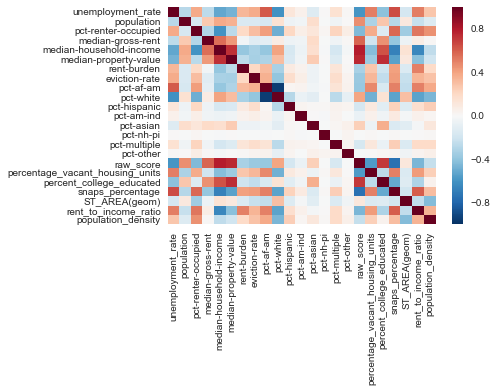

In [137]:
corr = df.corr()
sn.heatmap(corr, annot=False)
plt.show()

In [142]:
x_cols = [
    "unemployment_rate",
    "pct-renter-occupied", 
    "median-gross-rent",
    "median-household-income",
    "median-property-value",
    "rent-burden",
    'percentage_vacant_housing_units',
    'percent_college_educated',
    'snaps_percentage',
    'rent_to_income_ratio',
    'population_density',
    "pct-af-am",
    "pct-white",
    'pct-hispanic', 
    'pct-am-ind',
    'pct-asian', 
    'pct-nh-pi', 
    'pct-multiple', 
    'pct-other',
]

X = df[x_cols]
y = df[["eviction-rate"]]
print(X.shape, y.shape)

(7152, 13) (7152, 1)


In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# Linear Regression

In [144]:
model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 8.140792025515575, R2: 0.24791037958347206


In [145]:
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)

predictions = model.predict(X_test_scaled)
MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.7715167040596029, R2: 0.24791037958337792


# Epsilon-Support Vector Regression

In [162]:
from sklearn.svm import SVR

model = SVR(kernel='rbf')
model.fit(X_train_scaled, y_train_scaled)

predictions = model.predict(X_test_scaled)
MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

c:\users\art perkitny\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MSE: 0.7602282703332289, R2: 0.25891456626098863


# Categorical 

<AxesSubplot:>

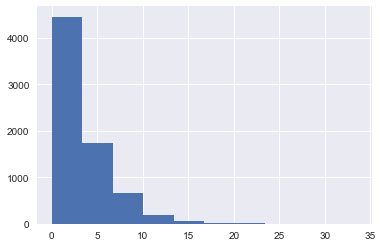

In [177]:
df["eviction-rate"].hist(bins=10)

In [276]:
import collections

def label_eviction_rates(rate):
    if rate<2:
        return "Low"
    elif rate<7:
        return "Medium"
    else:
        return "High"
    
df["label"] = df['eviction-rate'].apply(label_eviction_rates)
collections.Counter(df['eviction-rate'].apply(label_eviction_rates))

Counter({'High': 859, 'Low': 3133, 'Medium': 3160})

In [277]:
x_cols = [
    "unemployment_rate",
    "pct-renter-occupied", 
    "median-gross-rent",
    "median-household-income",
    "median-property-value",
    "rent-burden",
    'percentage_vacant_housing_units',
    'percent_college_educated',
    'snaps_percentage',
    'rent_to_income_ratio',
    'population_density',
    "pct-af-am",
    "pct-white",
    'pct-hispanic', 
    'pct-am-ind',
    'pct-asian', 
    'pct-nh-pi', 
    'pct-multiple', 
    'pct-other',
]

X = df[x_cols]
y = df[["label"]]
print(X.shape, y.shape)


(7152, 19) (7152, 1)


In [278]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_scaler = StandardScaler().fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# K Neighbors Classifier

k: 1, Train/Test Score: 1.000/0.483
k: 2, Train/Test Score: 0.746/0.487
k: 3, Train/Test Score: 0.739/0.522
k: 4, Train/Test Score: 0.699/0.540
k: 5, Train/Test Score: 0.688/0.541
k: 6, Train/Test Score: 0.668/0.555
k: 7, Train/Test Score: 0.661/0.551
k: 8, Train/Test Score: 0.655/0.550
k: 9, Train/Test Score: 0.657/0.558
k: 10, Train/Test Score: 0.643/0.562
k: 11, Train/Test Score: 0.641/0.559
k: 12, Train/Test Score: 0.638/0.564
k: 13, Train/Test Score: 0.634/0.558
k: 14, Train/Test Score: 0.636/0.574
k: 15, Train/Test Score: 0.629/0.572
k: 16, Train/Test Score: 0.630/0.573
k: 17, Train/Test Score: 0.624/0.567
k: 18, Train/Test Score: 0.622/0.571
k: 19, Train/Test Score: 0.622/0.566
k: 20, Train/Test Score: 0.625/0.570
k: 21, Train/Test Score: 0.626/0.573
k: 22, Train/Test Score: 0.621/0.578
k: 23, Train/Test Score: 0.623/0.568
k: 24, Train/Test Score: 0.622/0.577
k: 25, Train/Test Score: 0.622/0.573
k: 26, Train/Test Score: 0.617/0.576
k: 27, Train/Test Score: 0.616/0.573
k: 28, Tra

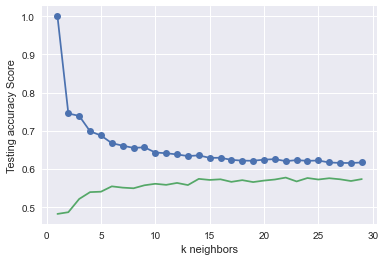

In [279]:
from sklearn.neighbors import KNeighborsClassifier

train_scores = []
test_scores = []
for k in range(1, 30, 1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 30, 1), train_scores, marker='o')
plt.plot(range(1, 30, 1), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [285]:
knn = KNeighborsClassifier(n_neighbors=22)
knn.fit(X_train_scaled, y_train)
print('Test Acc: %.3f' % knn.score(X_test_scaled, y_test))

Test Acc: 0.578


# Random Forest Classifier

k: 1, Train/Test Score: 0.813/0.497
k: 26, Train/Test Score: 1.000/0.601
k: 51, Train/Test Score: 1.000/0.613
k: 76, Train/Test Score: 1.000/0.614
k: 101, Train/Test Score: 1.000/0.609
k: 126, Train/Test Score: 1.000/0.608
k: 151, Train/Test Score: 1.000/0.617
k: 176, Train/Test Score: 1.000/0.614
k: 201, Train/Test Score: 1.000/0.615
k: 226, Train/Test Score: 1.000/0.615
k: 251, Train/Test Score: 1.000/0.610
k: 276, Train/Test Score: 1.000/0.607
k: 301, Train/Test Score: 1.000/0.608
k: 326, Train/Test Score: 1.000/0.615
k: 351, Train/Test Score: 1.000/0.614
k: 376, Train/Test Score: 1.000/0.616
k: 401, Train/Test Score: 1.000/0.615
k: 426, Train/Test Score: 1.000/0.610
k: 451, Train/Test Score: 1.000/0.611
k: 476, Train/Test Score: 1.000/0.610


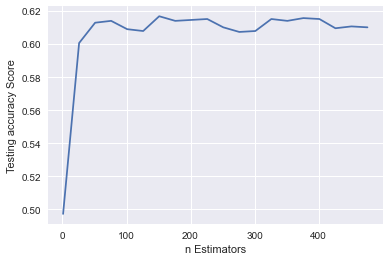

In [282]:
from sklearn.ensemble import RandomForestClassifier

train_scores = []
test_scores = []

for k in range(1, 501, 25):
    rf = RandomForestClassifier(n_estimators=k)
    rf = rf.fit(X_train_scaled, y_train)
    train_score = rf.score(X_train_scaled, y_train)
    test_score = rf.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
# plt.plot(range(1, 501, 25), train_scores, marker='o')
plt.plot(range(1, 501, 25), test_scores, marker="x")
plt.xlabel("n Estimators")
plt.ylabel("Testing accuracy Score")
plt.show()

In [287]:
rf = RandomForestClassifier(n_estimators=376)
rf.fit(X_train_scaled, y_train)
print('Test Acc: %.3f' % rf.score(X_test_scaled, y_test))

Test Acc: 0.609


# Analysis of Results 

In [289]:
for n, prediction in enumerate(rf.predict(X_test)):
    actual = y_test.iloc[n].item()
    if prediction == "Low" and actual == "High":
        print(n, prediction, actual)
    elif prediction == "High" and actual =="Low":
        print(n, prediction, actual)

In [333]:
collections.Counter(rf.predict(X_test))

Counter({'Low': 10, 'Medium': 1778})

In [339]:
collections.Counter(y_test.label)

Counter({'High': 218, 'Low': 791, 'Medium': 779})

In [288]:
sorted(zip(rf.feature_importances_, x_cols), reverse=True)

[(0.08206484680610515, 'median-property-value'),
 (0.08060762931987885, 'snaps_percentage'),
 (0.07702989604264715, 'pct-white'),
 (0.07579973307905041, 'population_density'),
 (0.06578686705856548, 'pct-af-am'),
 (0.06484788581343741, 'median-household-income'),
 (0.06445445293143799, 'pct-renter-occupied'),
 (0.06380796376256019, 'percent_college_educated'),
 (0.06291643944421654, 'rent_to_income_ratio'),
 (0.06253534094954244, 'unemployment_rate'),
 (0.0575128695314331, 'median-gross-rent'),
 (0.056056227606735586, 'percentage_vacant_housing_units'),
 (0.0515500114385969, 'rent-burden'),
 (0.04521535292791431, 'pct-multiple'),
 (0.041308508309319744, 'pct-hispanic'),
 (0.026306476926908764, 'pct-asian'),
 (0.013555974399122223, 'pct-am-ind'),
 (0.006946914345864947, 'pct-other'),
 (0.001696609306662753, 'pct-nh-pi')]

In [293]:
df_predicted = df
df_predicted['predicted'] = rf.predict(df[x_cols])

In [322]:
gdf = gp.read_file("ohio.shp")
gdf = gdf.to_crs(epsg=3857)

In [323]:
gdf = gdf.merge(df_predicted, left_on="GEO_ID", right_on="GEOID")

In [327]:
gdf.label

0       Medium
1       Medium
2       Medium
3       Medium
4       Medium
5       Medium
6       Medium
7       Medium
8       Medium
9         High
10         Low
11         Low
12         Low
13         Low
14      Medium
15      Medium
16      Medium
17      Medium
18      Medium
19         Low
20         Low
21         Low
22        High
23      Medium
24      Medium
25         Low
26      Medium
27      Medium
28        High
29      Medium
         ...  
1219    Medium
1220      High
1221       Low
1222       Low
1223    Medium
1224    Medium
1225       Low
1226    Medium
1227       Low
1228    Medium
1229    Medium
1230       Low
1231    Medium
1232       Low
1233       Low
1234    Medium
1235    Medium
1236    Medium
1237       Low
1238       Low
1239    Medium
1240    Medium
1241    Medium
1242    Medium
1243    Medium
1244    Medium
1245       Low
1246    Medium
1247      High
1248       Low
Name: label, Length: 1249, dtype: object

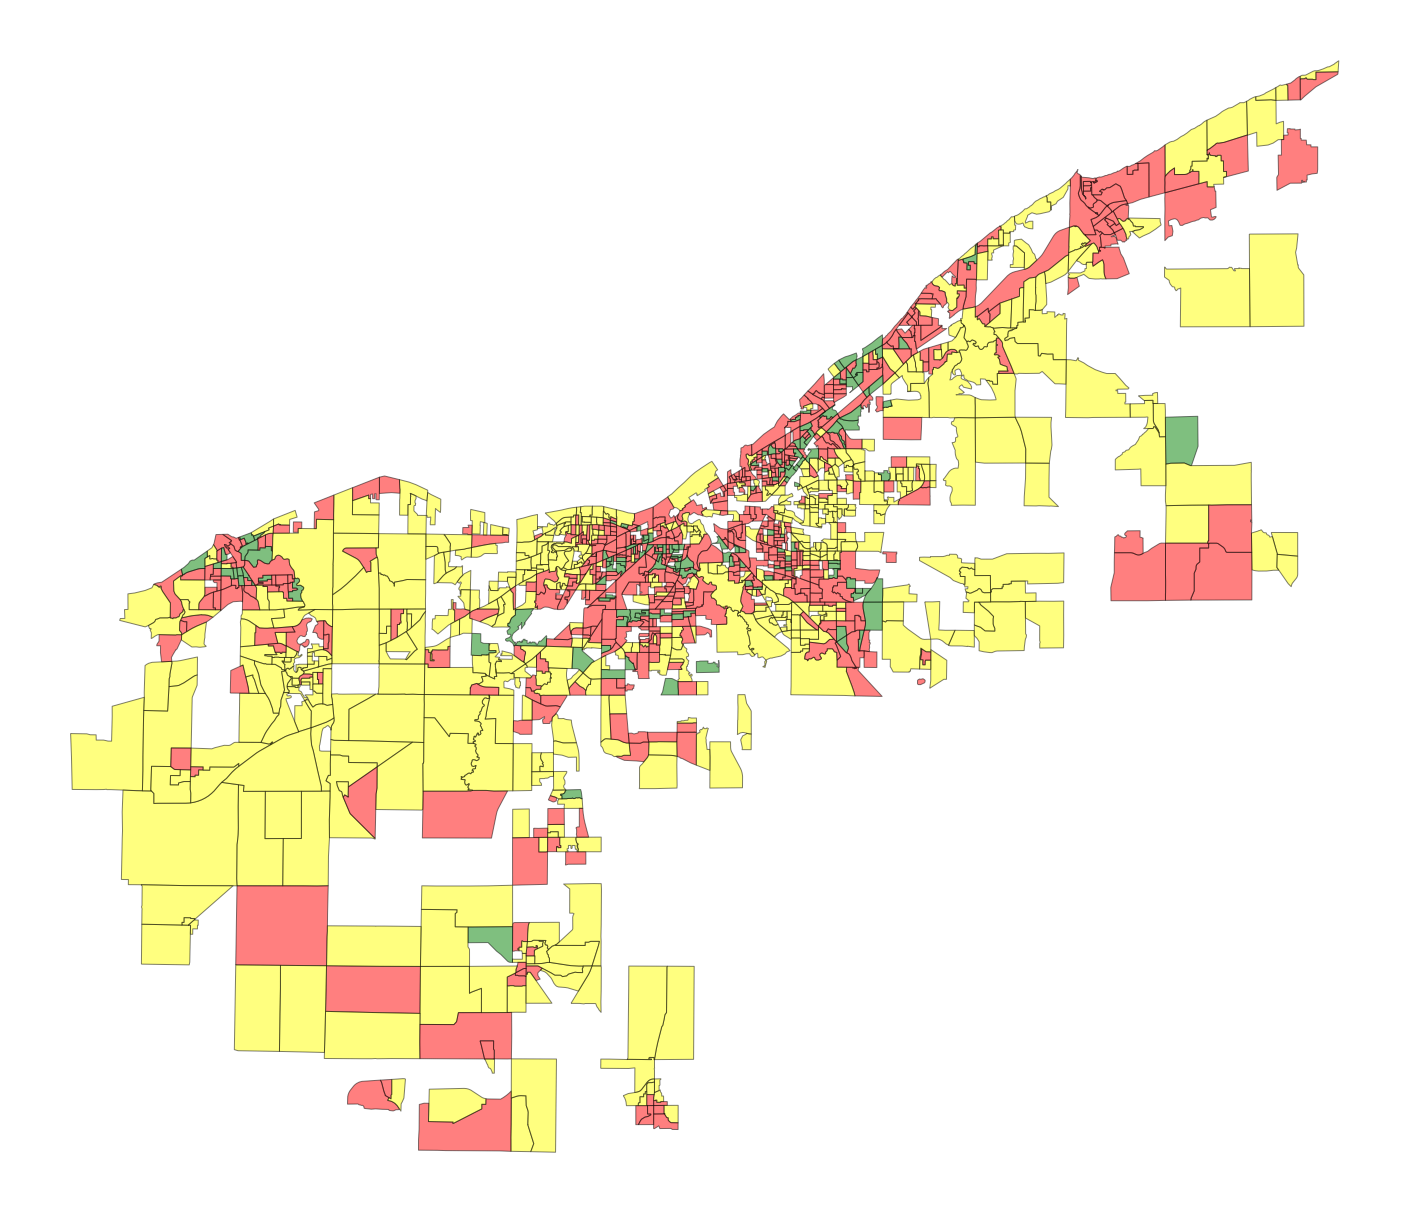

In [328]:
import matplotlib
column = "label"
# vmin = tracts[column].min()
# vmax = tracts[column].max()

ax = gdf.plot(
    column=column,
    cmap=matplotlib.colors.ListedColormap(["green","yellow","red"]),
    figsize=(25, 25),
    alpha=0.5,
    edgecolor='black',
    linewidth=1,
)

# util.add_basemap(ax, zoom=12, url=ctx.sources.ST_TONER_LITE)

ax.set_axis_off()
fig = ax.get_figure()

# cbax = fig.add_axes([0.95, 0.25, 0.03, 0.5])   
# cbax.set_title("Price to Rent Ratio", fontsize= 15)
# sm = plt.cm.ScalarMappable(cmap=CMAP, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# sm._A = []
# fig.colorbar(sm, cax=cbax)

# matplotlib.rcParams.update({'font.size': 20})
# ax.set_title('Price to Rent by Census Tract within Cleveland, OH', fontdict={
#     'fontsize': 30, 'fontweight': 'medium'})

# plt.savefig('images/Local_Price_to_Rent_Ratio.jpg',  dpi=300, bbox_inches = "tight")
plt.show()

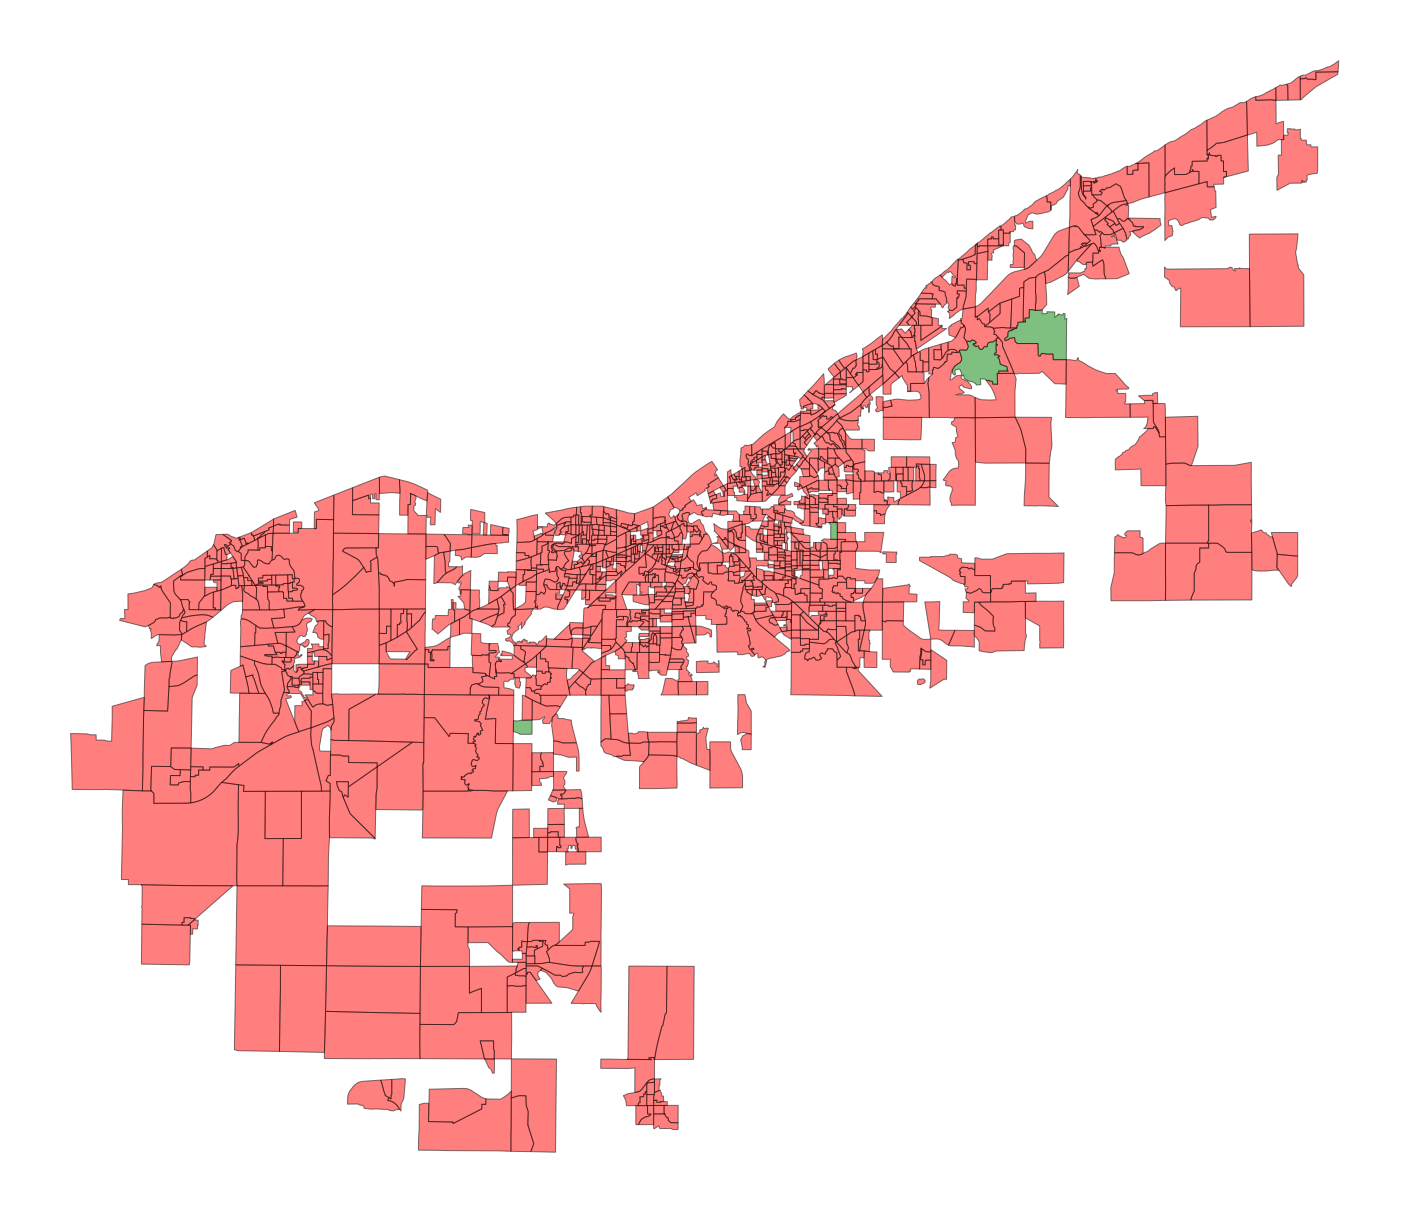

In [329]:
import matplotlib
column = "predicted"
# vmin = tracts[column].min()
# vmax = tracts[column].max()

ax = gdf.plot(
    column=column,
    cmap=matplotlib.colors.ListedColormap(["green","yellow","red"]),
    figsize=(25, 25),
    alpha=0.5,
    edgecolor='black',
    linewidth=1,
)

# util.add_basemap(ax, zoom=12, url=ctx.sources.ST_TONER_LITE)

ax.set_axis_off()
fig = ax.get_figure()

# cbax = fig.add_axes([0.95, 0.25, 0.03, 0.5])   
# cbax.set_title("Price to Rent Ratio", fontsize= 15)
# sm = plt.cm.ScalarMappable(cmap=CMAP, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# sm._A = []
# fig.colorbar(sm, cax=cbax)

# matplotlib.rcParams.update({'font.size': 20})
# ax.set_title('Price to Rent by Census Tract within Cleveland, OH', fontdict={
#     'fontsize': 30, 'fontweight': 'medium'})

# plt.savefig('images/Local_Price_to_Rent_Ratio.jpg',  dpi=300, bbox_inches = "tight")
plt.show()

In [332]:
collections.Counter(df.predicted)

Counter({'Low': 36, 'Medium': 7116})

# Ideas
- Add occupation industry data
- Presence of subsidised housing and no-rent rent amount
- People in household
- Marriage status
- Age of tenants
- Tenure of tenants 
- Computer and internet use
- Native or foreign born
- Year built
- Units in struct
- Rooms
- Bedrooms
- Vehicles avaiable
- Heating type
- Complete facilities
- Telephone service
- Occupents per room
